import the dataset

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/blackbox/creditcard.csv'
df = pd.read_csv(file_path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


we can avoid the time column and scale the amount column

In [3]:
from sklearn.preprocessing import StandardScaler

# Drop 'Time'
df = df.drop(columns=['Time'])

# Scale 'Amount'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [5]:
# Stratified sampling: keep fraud ratio (~0.17%)
df_sampled = df.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.017 if x.name == 0 else 1.0, random_state=42))

print("Sampled dataset shape:", df_sampled.shape)
print(df_sampled['Class'].value_counts())

Sampled dataset shape: (5325, 30)
Class
0    4833
1     492
Name: count, dtype: int64


/tmp/ipython-input-5-1390080289.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=0.017 if x.name == 0 else 1.0, random_state=42))


In [6]:
# Features and labels
X = df_sampled.drop(columns=['Class'])
y = df_sampled['Class']

In [7]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(X)

IsolationForest(random_state=42)

In [8]:
# Predict: -1 for anomaly, 1 for normal
preds = iso_forest.predict(X)

# Convert to 1 for anomaly, 0 for normal
y_pred = [1 if p == -1 else 0 for p in preds]

ROC-AUC Score: 0.7499571038540924
Confusion Matrix:
 [[4754   79]
 [ 238  254]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      4833
           1       0.76      0.52      0.62       492

    accuracy                           0.94      5325
   macro avg       0.86      0.75      0.79      5325
weighted avg       0.93      0.94      0.94      5325



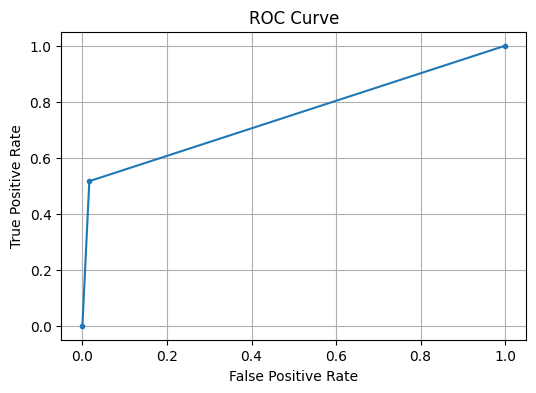

In [9]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

# ROC-AUC
roc_score = roc_auc_score(y, y_pred)
print("ROC-AUC Score:", roc_score)

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()